In [1]:
import torch

In [2]:
from IPython.display import Image

import numpy as np
import torchvision
from torch import nn, optim

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

#### Generating the MNIST Dataset

In [3]:
class MNIST:
    def __init__(self, batch_size, splits=None, shuffle=True):
        """
        Args:
          batch_size : number of samples per batch
          splits : [train_frac, valid_frac]
          shuffle : (bool)
        """
        # flatten the images
        self.transform = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(),
             torchvision.transforms.Lambda(lambda x: x.view(-1))])       

        self.batch_size = batch_size
        self.splits = splits
        self.shuffle = shuffle

        self._build()
      
    def _build(self):
        train_split, valid_split = self.splits
        trainset = torchvision.datasets.MNIST(
                root="data", train=True, download=True, transform=self.transform)
        num_samples = len(trainset)
        self.num_train_samples = int(train_split * num_samples)
        self.num_valid_samples = int(valid_split * num_samples)

        # create training set 
        self.train_dataset = torch.utils.data.Subset(
            trainset, range(0, self.num_train_samples))
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )
        
        # create validation set
        self.valid_dataset = torch.utils.data.Subset(
            trainset, range(self.num_train_samples, num_samples))
        self.valid_loader = torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

        # create test set
        self.test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                root="data", train=False, download=True, transform=self.transform
            ),
            batch_size=self.batch_size,
            shuffle=False,
        )
        self.num_test_samples = len(self.test_loader.dataset)

    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, idx, split="train"):
        if split == "train":
            return next(iter(self.train_loader))
        elif split == "valid":
            return next(iter(self.valid_loader))
        elif split == "test":
            return next(iter(self.test_loader))

### Visualizing the Dataset

In [9]:
dataset = MNIST(batch_size=10, splits=[0.6, 0.4])

In [10]:
x, y = dataset.get_batch(0, split="train")

##### Original Data

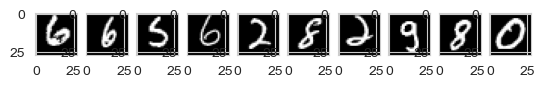

In [28]:
f, axarr = plt.subplots(1, 10)

for i in range(10):
  axarr[i].imshow(x[i].reshape(28,28), cmap="gray")

plt.show()

### Building the Model

In [ ]:
class Autoencoder(nn.Module):
    """
    Autoencoder defines a general class of NN architectures
           _____________                                     ___________
          |             |                                   |           |                    
    x --> | ENCODER (A) | --> z (latent representation) --> |DECODER (B)| --> x'
          |_____________|                                   |___________|          

    We implement a generic autoencoder with a fully connected encoder and decoder.
    The encoder and decoder are defined by a list of hidden layer sizes. 
    Note that while this architecture is "symmetric" in dimensionality,
    the encoder and decoder can have different architectures.
    """
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def _build_encoder(self):
        layers = []
        prev_size = self.input_size
        for layer_id, size in enumerate(self.hidden_sizes):
            layers.append(nn.Linear(prev_size, size))
            if layer_id < len(self.hidden_sizes)-1:
                layers.append(self.activation())
            prev_size = size
        return nn.Sequential(*layers)

    def _build_decoder(self):
        layers = []
        prev_size = self.hidden_sizes[-1]
        for size in reversed(self.hidden_sizes[:-1]):
            layers.append(nn.Linear(prev_size, size))
            layers.append(self.activation())
            prev_size = size
        layers.append(nn.Linear(prev_size, self.input_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat
    
    def get_loss(self, x):
        x_hat = self(x)
        return self.loss(x, x_hat)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def loss(self, x, x_hat):
        return nn.functional.mse_loss(x, x_hat)

    def train_step(self, x, optimizer):
        x_hat = self(x)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [ ]:
# masked autoencoder
class MaskedAutoencoder(Autoencoder):
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU, mask_prob=0.25):
        super().__init__(input_size, hidden_sizes, activation)
        self.mask_prob = mask_prob

    def train_step(self, x, optimizer):
        mask = torch.from_numpy(np.random.binomial(1, self.mask_prob, x.shape)).float()
        x_masked = x * mask
        x_hat = self(x_masked)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [ ]:
# scaled masked autoencoder
class ScaledMaskedAutoencoder(Autoencoder):
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU, mask_prob=0.25):
        super().__init__(input_size, hidden_sizes, activation)
        self.mask_prob = mask_prob

    def train_step(self, x, optimizer):
        mask = torch.from_numpy(np.random.binomial(1, self.mask_prob, x.shape)).float()
        x_masked = (1/self.mask_prob) * x * mask
        x_hat = self(x_masked)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

### Running the Model Code

In [ ]:
# training/plotting utilities

def plotter(train_losses, test_losses, savepath=None):
    plt.figure(figsize=(12, 8))

    MODELS = train_losses.keys()
    num_models = len(MODELS)
    colors = cm.rainbow(np.linspace(0, 1, num_models))
    for idx, model in enumerate(MODELS):
        plt.plot(
            train_losses[model],
            linewidth=2,
            label=model,
            color=colors[idx])
        plt.plot(
            test_losses[model],
            linewidth=2,
            linestyle='-.',
            label=model + "_test",
            color=colors[idx])
    plt.xlabel("#Epochs", fontsize=16)
    plt.ylabel("Avg. Loss", fontsize=16)
    plt.title("Comparing training w/ different AE architectures", fontsize=24)
    plt.legend(fontsize=14)
    if savepath:
        plt.savefig(savepath)


class Experiment:
    def __init__(self, dataset, model, batch_size=100, num_classes=2):
        self.batch_size = batch_size
        self.dataset = dataset
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        self.num_classes = num_classes

    def train(self, num_epochs=100):
        train_losses, valid_losses = [], []

        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_train_samples // self.batch_size

        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                loss = self.model.train_step(x, self.optimizer)

                # update progress
                pbar.set_description(f"Epoch {epoch}, Loss {loss.item():.4f}")

            # evaluate loss on valid dataset
            train_loss = self.get_loss(split="train")
            valid_loss = self.get_loss(split="valid")
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
        return {"train_losses": train_losses, "valid_losses": valid_losses}

    def get_loss(self, split="train"):
        num_samples = self.dataset.get_num_samples(split=split)
        num_batches = num_samples // self.batch_size
        losses = []
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split=split)
            loss = self.model.get_loss(x)
            losses.append(loss.item())
        return np.mean(losses)

    def get_model_accuracy(self, classifier, split="test"):
        """
        Compute the model accuracy with a linear classifer.
        """
        num_samples, num_correct = 0, 0
        num_batches = self.dataset.num_test_samples // self.batch_size
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split="test")
            z = self.model.encode(x)
            y_hat = classifier(z)
            preds = (y_hat.argmax(dim=1) == y).numpy()
            num_samples += len(preds)
            num_correct += np.sum(preds)
        return num_correct / num_samples
        
    def evaluate_w_linear_probe(self, feats_dim, num_epochs=10):
        # create a classifier
        probe = nn.Linear(feats_dim, self.num_classes)

        # setup optimizer
        probe_opt = optim.Adam(probe.parameters(), lr=1e-3)

        # train linear probe
        # note that we train on a small subset of the labelled data 
        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_valid_samples // self.batch_size

        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                feat = self.model.encode(x)
                y_hat = probe(feat)

                # compute loss, optimize
                loss = nn.functional.cross_entropy(y_hat, y)
                probe_opt.zero_grad()
                loss.backward()
                probe_opt.step()

                # update progress
                pbar.set_description(
                    f"Epoch {epoch}, Loss {loss.item():.4f}")
        
        # evaluate linear probe
        accuracy = self.get_model_accuracy(classifier=probe)
        return {"accuracy": accuracy}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskedAutoencoder(input_shape=784).to(device)

In [ ]:
NUM_REPEATS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 200

##########################################
####### TODO : define model architecture 
# hidden dims is a list of ints
INPUT_DIMS = 784
NUM_CLASSES = 10
ACTIVATION = torch.nn.Sigmoid
HIDDEN_DIMS = [100, 50, 5]
##########################################

# load and create MNIST dataset
dataset = MNIST(BATCH_SIZE, [0.6, 0.4])

# logging metrics
feats_dim = HIDDEN_DIMS[-1]
train_losses, test_losses = {}, {}
accuracy = {}

# run experiment w/ different models
for model_idx, model_cls in MODELS.items():
    _train_loss, _valid_loss, _acc = [], [], []
    for expid in range(NUM_REPEATS):
        print("run : {},  model : {}".format(expid, model_idx))
        model = model_cls(INPUT_DIMS, HIDDEN_DIMS, activation=ACTIVATION)
        experiment = Experiment(dataset, model, num_classes=NUM_CLASSES)
        train_stats = experiment.train(num_epochs=NUM_EPOCHS)
        eval_stats = experiment.evaluate_w_linear_probe(feats_dim, NUM_EPOCHS)
        _train_loss.append(train_stats["train_losses"])
        _valid_loss.append(train_stats["valid_losses"])
        _acc.append(eval_stats["accuracy"])
      
    train_losses[model_idx] = np.mean(_train_loss, axis=0)
    test_losses[model_idx] = np.mean(_valid_loss, axis=0)
    accuracy[model_idx] = np.mean(_acc)

# plot losses
plotter(train_losses, test_losses)

# report accuracy
for model_idx, acc in accuracy.items():
    print("Model : {}, Accuracy : {}".format(model_idx, acc))

#### Zero Masking with normalization